# Pulse control

We review the fundamental elements required to build a pulse schedule following the appropriate [Qiskit tutorial](https://github.com/Qiskit/qiskit-iqx-tutorials/blob/1748699b49c44003c0e7505d0cd2249df25b973a/qiskit/advanced/terra/5_pulse_schedules.ipynb).

However the tutorial is incomplete. We switch half-way to the [Qiskit tutorial](https://github.com/Qiskit/qiskit-iqx-tutorials/blob/master/qiskit/advanced/ignis/1a_calibrating_a_qubit.ipynb) on Rabi experiments.

In [1]:
from qiskit import *

# Matplotlib is recommended for Qiskit.
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
%matplotlib inline

# Load account (requires a saved IBMQ user id) and list available backends.
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [2]:
# Jupyter widget for tracking IBMQ jobs.
import qiskit.tools.jupyter
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

ibmq_armonk


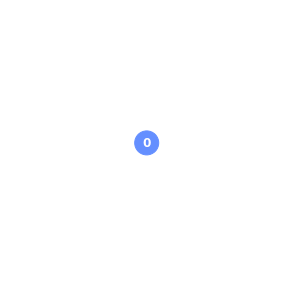

In [3]:
# Backend with right connectivity map for the five-qubit GHZ circuit.
backend = provider.get_backend(open_pulse=True)

# Set qasm as simulator.
simulator = Aer.get_backend('qasm_simulator')

# Print name and configuration of backend.
from qiskit.visualization import plot_gate_map
print(backend)
plot_gate_map(backend)

## Construction a pulse instruction

### Channels

Physical channels on the backend. `Channels` combined with `Commands` form an `Instruction`.

In [4]:
# Delcare the fundamental channels.
from qiskit.pulse.channels import (DriveChannel, MeasureChannel, ControlChannel, 
                                   AcquireChannel, MemorySlot)
drive_ch = DriveChannel(0)
meas_ch = MeasureChannel(0)
ctrl_ch = ControlChannel(0)
acqu_ch = AcquireChannel(0)
mem_sl = MemorySlot(0)

### Commands

Actions that can be completed on a device `Channel`. 

Can be used repeatedly. Some `Commands` are exclusive to specific `Channels`.

In [5]:
# Define a pulse, framechange and acquire.
from qiskit.pulse.commands import (SamplePulse, FrameChange, Acquire)
sine_pulse = SamplePulse(np.sin(np.linspace(0, 4*np.pi, 21)), name='sine_pulse')
pi_frame = FrameChange(np.pi, name='pi_frame')
acquire = Acquire(100, name='acquire')

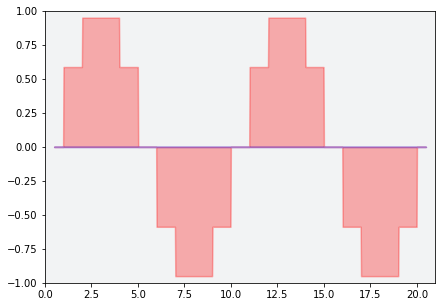

In [6]:
sine_pulse.draw()

### Instruction

Created by applying a `Command` to a `Channel`.

Each `Command` has a corresponding `Instruction` type.

In [7]:
# Create an instruction.
sine_inst = sine_pulse(drive_ch) # or sine_pulse.to_instruction(drive_ch)
acqu_inst = acquire(acqu_ch, mem_sl)

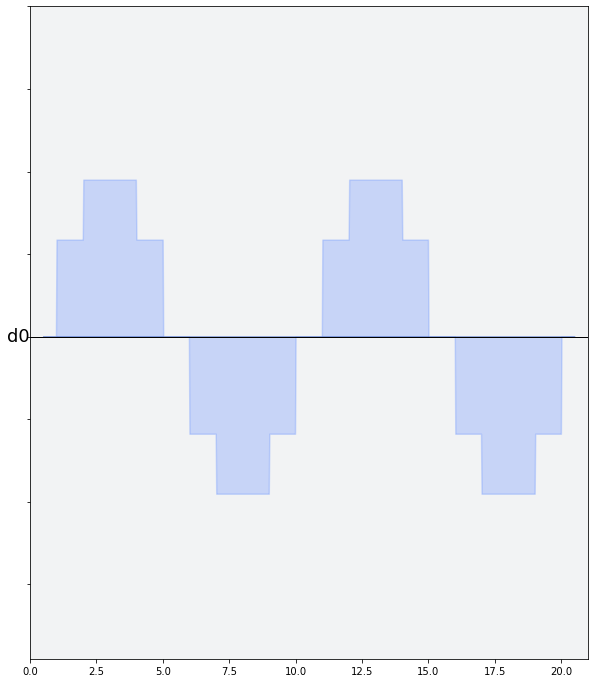

In [8]:
sine_inst.draw()

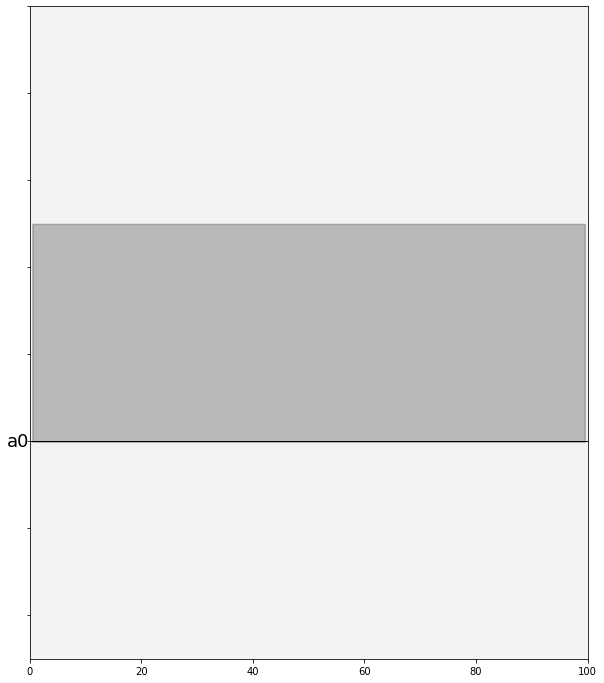

In [9]:
acqu_inst.draw()

### Schedules

Set of `Instructions` executed at specific times. 

`Schedules` can contain `schedules`.

Can be modified by doing `unions`, `shifts` and `appends`.

In [10]:
# Two unit schedules to pulse and acquire.
from qiskit.pulse import pulse_lib, Schedule
sine_sched = Schedule(sine_inst, name='sine_sched')
acqu_sched = Schedule((10, acqu_inst), name='acqu_sched')

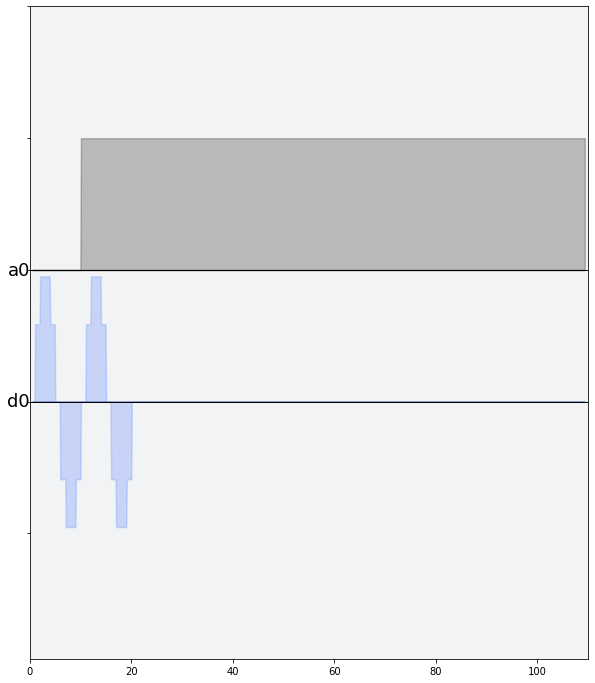

In [11]:
union_sched = sine_sched.union(acqu_sched)
union_sched.draw()

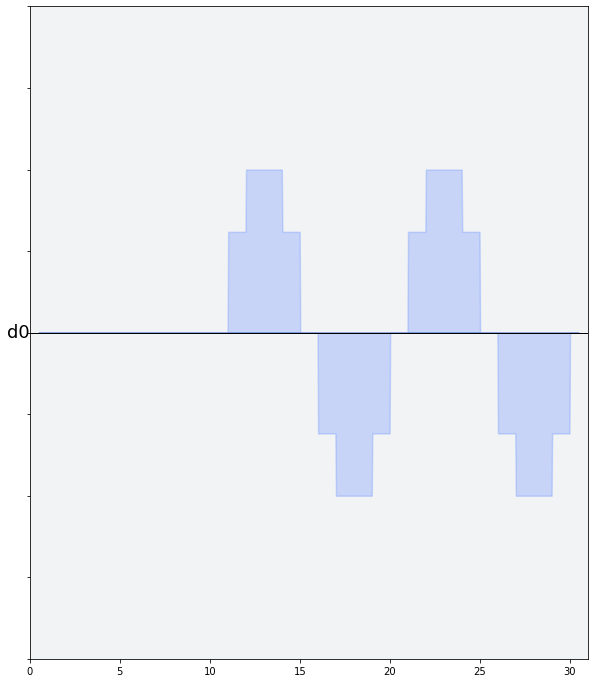

In [12]:
shift_sched = sine_sched.shift(10)
shift_sched.draw()

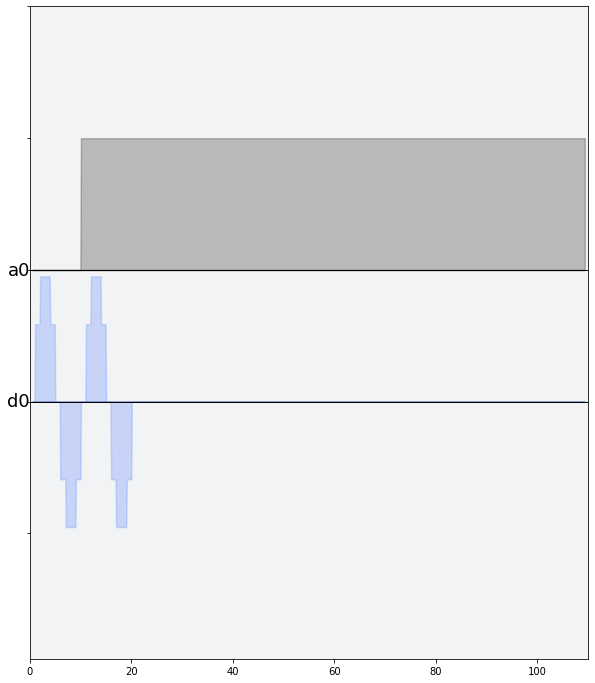

In [13]:
append_sched = sine_sched.append(acqu_sched)
append_sched.draw()

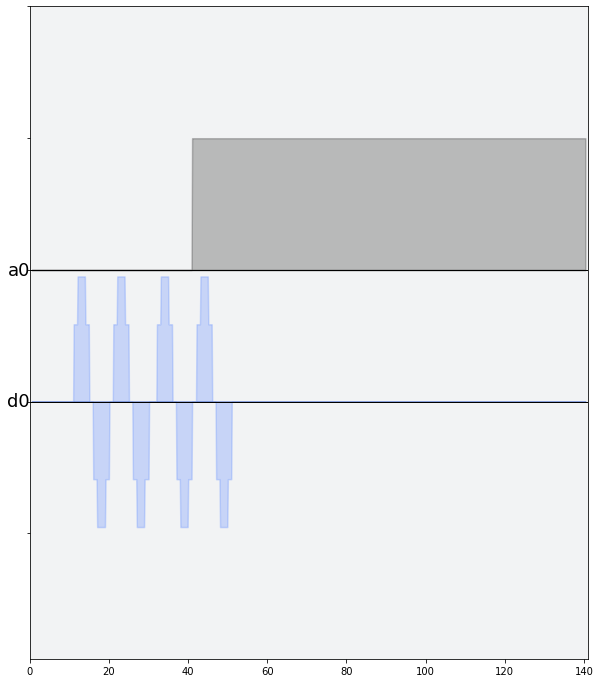

In [14]:
# Syntactic sugar, baby. 
# Can make schedules directly from instructions.
sched = Schedule(name='syntax_test')
sched |= sine_sched << 10
sched += acqu_sched + sine_sched
sched.draw()

## Rabi experiment

In [4]:
# Index of qubit.
qubit = 0

# Experimental configuration.
exps = 75
shots = 5000

# Rabi pulse parameters.
drive_amps = np.linspace(0, 1, exps)
drive_samples = 2048 # Pulse duration. Must be a multiple of 16.
drive_sigma = 256

# Scale factor for data returned from backend.
scale_factor = 1e-15

In [5]:
# Load information from backend.
config = backend.configuration()
defaults = backend.defaults()

# Obtain default pulses from backend.
circ_inst_map = defaults.instruction_schedule_map
measure = circ_inst_map.get('measure', qubits=config.meas_map[0])

# Create a set of Rabi experiment schedules.
# Each schedule involves a pulse followed by a measurement.
schedules=[]
from qiskit.pulse import pulse_lib, Schedule, DriveChannel
for idx, drive_amp in enumerate(drive_amps):
    
    # Gaussian pulse with an amplitude given by drive_amps.
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, sigma=drive_sigma, 
                                    name='rabi_pulse_%i' %idx)
    
    # Schedule drive pulse followed by measurement pulse.
    schedule = Schedule(name='Rabi at drive amp = %1.2f' %drive_amp)
    schedule |= rabi_pulse(DriveChannel(qubit)) # Drive pulse
    schedule |= measure << schedule.duration
    
    schedules.append(schedule)

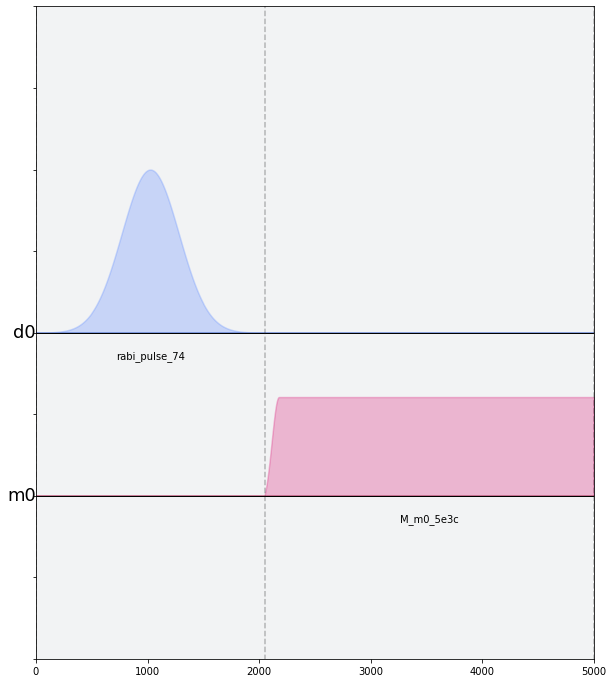

In [6]:
# Draw last schedule (max amplitude).
from qiskit.pulse import MeasureChannel
schedule.draw(channels=[DriveChannel(qubit), MeasureChannel(qubit)], label=True, 
              plot_range=[0, 5000])

In [18]:
# Assemble jobs to run on backend.
from qiskit.compiler import assemble
from qiskit.qobj.utils import MeasLevel, MeasReturnType
jobs = assemble(schedules, backend, shots=shots,
                meas_level=MeasLevel.KERNELED, meas_return=MeasReturnType.AVERAGE)

/Users/thomassmith/anaconda3/lib/python3.7/site-packages/qiskit/providers/models/pulsedefaults.py:155: UserWarning: `qubit_freq_est` and `meas_freq_est` now have units of Hertz(Hz) rather than gigahertz(GHz).
  warnings.warn('`qubit_freq_est` and `meas_freq_est` now have units of '
/Users/thomassmith/anaconda3/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:377: UserWarning: `rep_time` now has units of seconds(s) rather than microseconds(mu s).
  warnings.warn('`rep_time` now has units of seconds(s) rather '


In [19]:
# Run jobs on backend.
job = backend.run(jobs)
print(job.job_id())
result = job.result()

5e4b3f787f49c800112ded30


In [20]:
# Obtain measurement signal from jobs.
data = np.zeros(exps, dtype=np.complex)
for idx in range(exps):
    data[idx] = result.get_memory(idx)[qubit] * scale_factor

In [21]:
# Function to get the amplitude from complex-valued signal.
def get_amplitude(vec):
    i_signal = np.imag(vec)
    r_signal = np.real(vec)

    mvec = [np.mean(r_signal), np.mean(i_signal)]

    src_mat = np.vstack((r_signal - mvec[0], i_signal - mvec[1])).T
    (_, _, v_mat) = np.linalg.svd(src_mat)

    dvec = v_mat[0, 0:2]

    if dvec.dot(mvec) < 0:
        dvec = -dvec

    return src_mat.dot(dvec)

0.3304196982167326


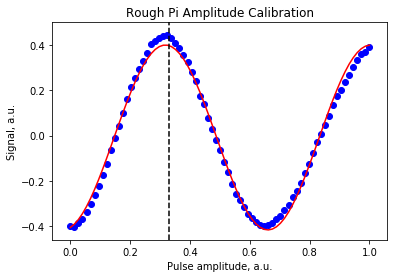

In [55]:
# Get signal amplitudes from jobs.
data_amps = get_amplitude(data)

# Fit data to a sinusoid.
from scipy.optimize import curve_fit
fit_func = lambda x, A, B, omeg, phi : (A * np.cos((2*np.pi)*omeg*x + phi) + B)
fit_params, conv = curve_fit(fit_func, drive_amps, data_amps, [0.4, 0.0, 0.6, 0])

# Amplitude for a pi pulse.
pi_amp = (np.pi - fit_params[3])/2 / (2*np.pi * fit_params[2])
print(pi_amp)

# Plot data and fit.
plt.scatter(drive_amps, data_amps, c='blue')
plt.plot(drive_amps, fit_func(drive_amps, *fit_params), c='red')
plt.axvline(pi_amp, c='k', ls='--')

plt.xlabel('Pulse amplitude, a.u.');
plt.ylabel('Signal, a.u.');
plt.title('Rough Pi Amplitude Calibration');

## IQ experiment 

In [23]:
# Create Rabi flip experiment schedule.
# Gaussian pi pulse.
rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=pi_amp, sigma=drive_sigma, 
                                name='pi_pulse')
# Schedule: rabi pi pulse then measure.
excited = Schedule(name='pi_exp')
excited |= rabi_pulse(DriveChannel(qubit))
excited |= measure << rabi_pulse.duration

# Schedule: no pulse then measure.
ground = Schedule(name='nopi_exp')
ground |= measure << rabi_pulse.duration

# Assemble jobs to run on backend.
schedules = [ground, excited]
jobs = assemble(schedules, backend, shots=5000,
                meas_level=MeasLevel.KERNELED, meas_return=MeasReturnType.SINGLE)

In [24]:
# Run jobs on backend.
job = backend.run(jobs)
print(job.job_id())
result = job.result()

5e4b41464efd350011162b8c


In [25]:
# Obtain measurement signal from jobs.
ground_data = result.get_memory(0)[:,qubit] * scale_factor
excited_data  = result.get_memory(1)[:,qubit] * scale_factor

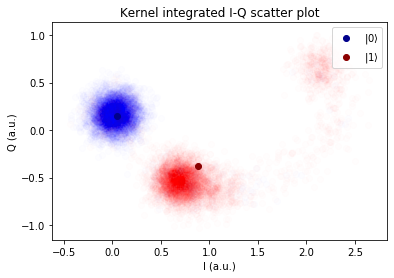

In [61]:
# IQ plot of shots
plt.scatter(np.real(ground_data), np.imag(ground_data), c='b', alpha=0.008)
plt.scatter(np.real(excited_data), np.imag(excited_data), c='r', alpha=0.008)

ground_center = np.mean(ground_data)
excited_center = np.mean(excited_data)
plt.scatter(np.real(ground_center), np.imag(ground_center), c='darkblue', alpha=1.0, label=r'$|0\rangle$')
plt.scatter(np.real(excited_center), np.imag(excited_center), c='darkred', alpha=1.0, label=r'$|1\rangle$')

plt.title('Kernel integrated I-Q scatter plot');
plt.legend(loc='upper right');
plt.xlabel('I (a.u.)');
plt.ylabel('Q (a.u.)');